In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import math

In [2]:
def image_preprocesing(name):
    image = cv2.imread(name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 1)
    thresh = cv2.threshold(blur,50,1,cv2.THRESH_BINARY_INV)[1]
    return image

## Cargando cuatro imágenes consecutivas en los que se vean claramente un sunspot

In [3]:
#image11=image_preprocesing("sunspot_20220707.jpg")
#image21=image_preprocesing("sunspot_20220708.jpg")
#image31=image_preprocesing("sunspot_20220709.jpg")
#image41=image_preprocesing("sunspot_20220710.jpg")

In [4]:
def GetSunRadius(image):
    Cx,Cy=image.shape[0]//2,image.shape[1]//2
    a=image[Cx].sum(axis=1)
    indices=np.array([index for index, item in enumerate(a) if item==min(a)])
    ind=indices[indices<round(Cx)].max()
    r=Cx-ind
    return Cx,Cy,r,ind

In [5]:
#draw a circle
def DrawCirc(image):
    Cx,Cy,r,ind=GetSunRadius(image)
    angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
    xs = r*np.cos(angles)
    ys = r*np.sin(angles)
    return plt.plot(xs+Cx, ys+Cx, color = 'r')

In [6]:
def get_julian_datetime(date):
    """
    Convert a datetime object into julian float.
    Args:
        date: datetime-object of date in question
    Returns: float - Julian calculated datetime.
    Raises: 
        TypeError : Incorrect parameter type
        ValueError: Date out of range of equation
    """
    # Ensure correct format
    if not isinstance(date,datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year<1801 or date.year>2099:
        raise ValueError('Datetime must be between year 1801 and 2099')
    # Perform the calculation
    julian_datetime=367*date.year-\
                    int((7*(date.year+int((date.month+9)/12.0)))/4.0)+\
                    int((275*date.month)/9.0)+date.day+1721013.5+\
                    (date.hour+date.minute/60.0+date.second/math.pow(60,2))/24.0-\
                    0.5*math.copysign(1,100*date.year+date.month-190002.5)+0.5
    return julian_datetime

In [7]:
def getQuadrantby_eina(eina):
    eina_ = eina % 360
    eina_1 = []
    if eina_ > 0 and eina_ <= 90:
        eina_1.append(1)
    if eina_ > 90 and eina_ <= 180:
        eina_1.append(2)
    if eina_ > 180 and eina_ <= 270:
        eina_1.append(3)
    if eina_ > 270 and eina_ <= 360:
        eina_1.append(4)
    return eina_1

In [8]:
def GetB0L0(year, month, day, hour, minute):
    '''http://www.petermeadows.com/html/location.html'''
    date = datetime.datetime(year,month,day,hour, minute)
    JD=get_julian_datetime(date)
    T=(JD-2451545.0)/36525
    LL=(280.46646+36000.76983*T+0.0003032*T**2)%360
    M=(357.52911+35999.05029*T-0.000153*T**2)%360
    C=(1.914602-0.004817*T-0.000014*T**2)*np.sin(np.radians(M))+\
            (0.019993-0.000101*T)*np.sin(2*np.radians(M))+0.000289*np.sin(3*np.radians(M))
    O_=LL+C
    Womiuga=125.04-1934.136*T
    Lamda=O_-0.00569-0.00478*np.sin(np.radians(Womiuga))
    Lamda_=O_-1.397*T-0.00031*T**2
    # Astronomical Algorithms 22.2
    epxlong0=23+26/60+21.448/3600-46.8150/3600*T-0.00059/3600*T**2+0.001813/3600*T**3
    L_=280.4665+36000.27698*T
    L__=218.3165+481267.28813*T
    Q=(125.04452-1934.136261*T+0.0020708*T**2+T**3/450000)%360
    # % Astronomical Algorithms P144
    depxlong=9.20/3600*np.cos(Q*np.pi/180)+0.57/3600*np.cos(2*np.radians(L_))+\
            0.1/3600*np.cos(2*np.radians(L__))-0.09/3600*np.cos(2*np.radians(Q))
    
    epxlong=epxlong0+depxlong
    sita=((JD-2398220)*360/25.38)%360
    I=7.25
    K=73.6667+1.3958333*(JD-2396758)/36525
    x=np.degrees(np.arctan(-np.cos(np.radians(Lamda_))*np.tan(np.radians(epxlong))))
    y=np.degrees(np.arctan(-np.cos(np.radians(Lamda-K))*np.tan(np.radians(I))))
    P=x+y
    
    # B0: the heliographic latitude of the center of the solar disk
    B0=np.degrees(np.arcsin(np.sin(np.radians(Lamda-K))*np.sin(np.radians(I))))
    
    eina=np.degrees(np.arctan(np.tan(np.radians(Lamda-K))*np.cos(np.radians(I))))
    LK=Lamda-K-180
    eina_1=getQuadrantby_eina(eina)[0]
    LK_1=getQuadrantby_eina(LK)[0]
    if eina_1==LK_1:
        eina=eina-180
    L0=(eina-sita-180)%360
    return JD, B0, L0, P

In [9]:
# taking two inputs coordinates at a time for each image
def get_coordinates(name):
    xs,ys=input("Enter two coordinates (xs,ys) from image {} (Separated by space): ".format(name)).split()
    xs,ys=float(xs),float(ys)
    return xs,ys

In [10]:
def Calculation1(date):
    #https://www.cosmos.esa.int/documents/519784/1185714/teachers_guide/6fd53676-55b4-415d-9fff-e27f6270ca70
    name="sunspot_"+date+".jpg"
    year,month,day=int(date[0:4]),int(date[4:6]),int(date[6:8])
    Cx,Cy,R,ind=GetSunRadius(image_preprocesing(name))
    JD,B0,L0,P=GetB0L0(year,month,day,0,0)
    coordx,coordy=get_coordinates(name)
    Xs,Ys=coordx-Cx,Cy-coordy
    Pm,Rm=180-np.degrees(np.arctan2(Xs,Ys)),np.sqrt(Xs**2+Ys**2)
    #Calculating Latitude and longitude of the Sunspot
    d=0.54
    theta=np.radians(Pm)-np.radians(P)-np.pi
    alpha=np.arctan(Rm/R*np.tan(np.radians(d/2)))
    rho1=np.arcsin(np.sin(alpha)/np.sin(np.radians(d/2)))-alpha
    B1=np.degrees(np.arcsin(np.cos(rho1)*np.sin(np.radians(B0))+np.sin(rho1)*np.cos(np.radians(B0))*np.sin(theta)))
    l=np.arcsin(np.cos(theta)*np.sin(rho1)/np.cos(np.radians(B1)))
    L1=L0+np.degrees(l)
    rho2=np.radians(np.degrees(np.arcsin(Rm/R))-np.radians(d)*(Rm/R))
    B2=np.degrees(np.arcsin(np.cos(rho2)*np.sin(np.radians(B0))+np.sin(rho2)*np.cos(np.radians(B0))*np.cos(np.radians(P-Pm))))
    L2=L0+np.degrees(np.arcsin(np.sin(np.radians(P-Pm))*np.sin(rho2)*np.cos(np.radians(B2))))
    return B0, L0, P, B1, L1, coordx, coordy

In [11]:
#GetB0L0(2022,7,7,0,0)
#GetB0L0(1999,1,1,11,10)

## Un caso de estudio. Analizando imagénes de 20220707, 20220708, 20220709 y 20220710... **Mirando la mancha 3052...**

In [12]:
dates=["20220707","20220708","20220709","20220710"]

In [13]:
print("Coordenadas para 20220707 =",164.71,211.73,327.54,424.88)
print("Coordenadas para 20220707 =",210.32,212.35,420.72,426.69)
print("Coordenadas para 20220707 =",259.46,212.96,518.23,426.37)
print("Coordenadas para 20220707 =",308.39,213.88,615.32,427.79)

Coordenadas para 20220707 = 164.71 211.73 327.54 424.88
Coordenadas para 20220707 = 210.32 212.35 420.72 426.69
Coordenadas para 20220707 = 259.46 212.96 518.23 426.37
Coordenadas para 20220707 = 308.39 213.88 615.32 427.79


Enter two coordinates (xs,ys) from image sunspot_20220707.jpg (Separated by space):  327.54 424.88
Enter two coordinates (xs,ys) from image sunspot_20220708.jpg (Separated by space):  420.72 426.69
Enter two coordinates (xs,ys) from image sunspot_20220709.jpg (Separated by space):  518.23 426.37
Enter two coordinates (xs,ys) from image sunspot_20220710.jpg (Separated by space):  615.32 427.79


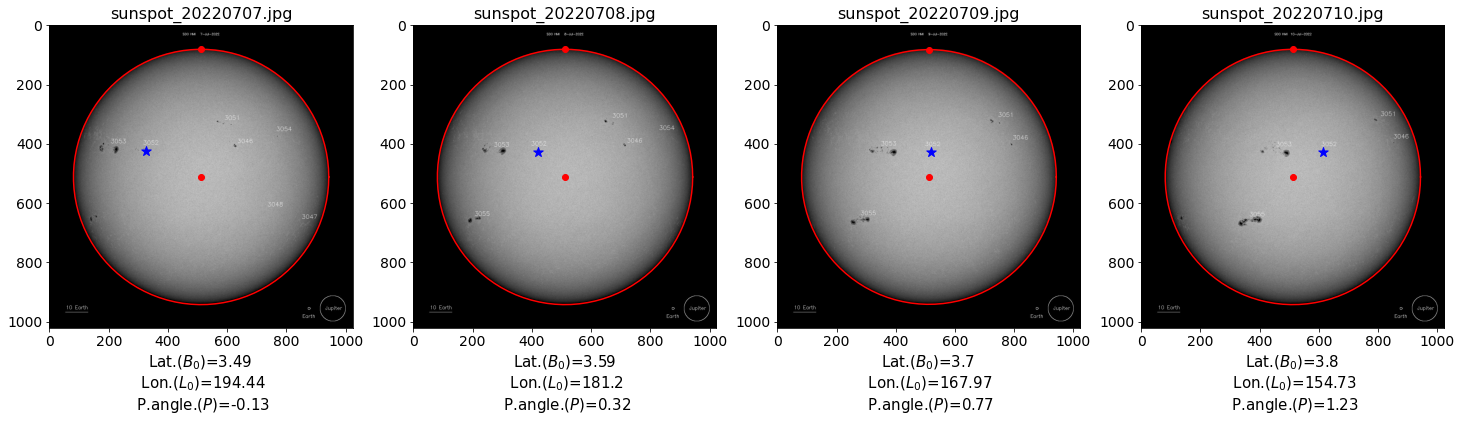

For image 1 and 2 $\Delta B$ is = 13.031 and Sun's rotation is about = 27.626 days
For image 2 and 3 $\Delta B$ is = 12.979 and Sun's rotation is about = 27.737 days
For image 3 and 4 $\Delta B$ is = 12.965 and Sun's rotation is about = 27.767 days
Average Sun's rotation is about = 27.71 days ($\sigma_T$ = 0.061)


In [14]:
plt.figure(figsize=(25,15))
B_calc,DAYS=[],[]
for i,j in enumerate(dates):
    plt.subplot(1,4,i+1)
    name="sunspot_"+j+".jpg"
    B0,L0,P,B,L,X,Y=Calculation1(j)
    plt.imshow(image_preprocesing(name))
    plt.scatter(image_preprocesing(name).shape[0]/2,image_preprocesing(name).shape[1]/2,c="r")
    plt.scatter(image_preprocesing(name).shape[1]/2,GetSunRadius(image_preprocesing(name))[3],c="r")
    plt.scatter(X,Y,c="b",marker="*",s=100)
    DrawCirc(image_preprocesing(name))
    plt.title(name,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Lat.($B_0$)={} \n Lon.($L_0$)={} \n P.angle.($P$)={}".format(np.round(B0,2),np.round(L0,2),np.round(P,2)),fontsize=15)
    B_calc.append(B)
    DAYS.append(float(j[6:8]))
plt.show()
DAYS=np.array(DAYS)
B_calc=np.array(B_calc)
DeltaDAYS=abs(np.diff(DAYS))
DeltaB=abs(np.diff(B_calc))
T=360*DeltaDAYS/DeltaB

print(r"For image 1 and 2 $\Delta B$ is = {} and Sun's rotation is about = {} days".format(np.round(DeltaB[0],3),np.round(T[0],3)))
print(r"For image 2 and 3 $\Delta B$ is = {} and Sun's rotation is about = {} days".format(np.round(DeltaB[1],3),np.round(T[1],3)))
print(r"For image 3 and 4 $\Delta B$ is = {} and Sun's rotation is about = {} days".format(np.round(DeltaB[2],3),np.round(T[2],3)))
print(r"Average Sun's rotation is about = {} days ($\sigma_T$ = {})".format(np.round(T.mean(),3),np.round(T.std(),3)))

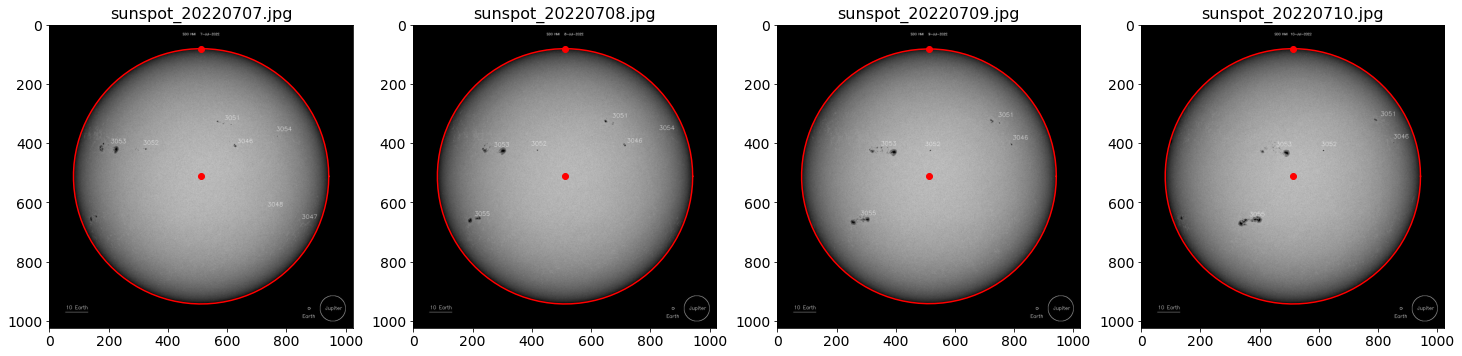

In [15]:
plt.figure(figsize=(25,15))
for i,j in enumerate(dates):
    plt.subplot(1,4,i+1)
    name="sunspot_"+j+".jpg"
    plt.imshow(image_preprocesing(name))
    plt.scatter(image_preprocesing(name).shape[0]/2,image_preprocesing(name).shape[1]/2,c="r")
    plt.scatter(image_preprocesing(name).shape[1]/2,GetSunRadius(image_preprocesing(name))[3],c="r")
    DrawCirc(image_preprocesing(name))
    plt.title(name,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.show()